In [1]:
# Mount Google Drive to access the dataset stored in 'eye_diseases' folder
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Path to the dataset in Google Drive
data_dir = '/content/drive/MyDrive/Dataset/dataset'

# Define ImageDataGenerators for training, validation, and test sets
# Data augmentation for training: rotation, zoom, and flip
# Train/Validation split: 80% train, 20% validation of 80% split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.05  # 95% for training, 5% for validation of the total 90%
)

# Test set does not require augmentation, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Training generator (90% of the data)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Training data (50% of 40%)
)

# Validation generator (5% of the data)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Validation data (50% of 20%)
)

# Test generator (5% of the data)
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No shuffling for test data
)

Found 4009 images belonging to 4 classes.
Found 208 images belonging to 4 classes.
Found 4217 images belonging to 4 classes.


In [7]:
# Load ResNet50 model pre-trained on ImageNet, without the top layer (include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for our 4-class problem
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling instead of flattening
x = Dense(1024, activation='relu')(x)  # Fully connected layer with ReLU activation
predictions = Dense(4, activation='softmax')(x)  # Output layer for 4 classes with softmax

# Create the final model by combining the base and custom layers
model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
# Compile the model with Adam optimizer and a low learning rate for transfer learning
model.compile(optimizer=Adam(learning_rate=0.0001),  # Low learning rate for fine-tuning
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])  # Track accuracy as the metric


In [9]:
# Train the model
history = model.fit(
    train_generator,  # Training data generator
    epochs=10,  # Number of epochs
    validation_data=validation_generator,  # Validation data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Steps per epoch
    validation_steps=validation_generator.samples // validation_generator.batch_size,  # Validation steps
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 2370s 17s/step - accuracy: 0.7631 - loss: 0.5829 - val_accuracy: 0.2552 - val_loss: 1.6541
Epoch 2/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 36s 297ms/step - accuracy: 0.8438 - loss: 0.3432

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.8438 - loss: 0.3432 - val_accuracy: 0.2500 - val_loss: 1.6306
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 739ms/step - accuracy: 0.9150 - loss: 0.2316 - val_accuracy: 0.2344 - val_loss: 1.7435
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.9375 - loss: 0.1345 - val_accuracy: 0.1875 - val_loss: 1.6378
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 139s 724ms/step - accuracy: 0.9333 - loss: 0.1684 - val_accuracy: 0.2552 - val_loss: 2.6868
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.0880 - val_accuracy: 0.3125 - val_loss: 3.0289
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 724ms/step - accuracy: 0.9440 - loss: 0.1375 - val_accuracy: 0.4219 - val_loss: 1.7573
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8889 - loss: 0.6048 - val_accuracy: 0.4375 - val_loss: 2.1105
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 755ms/step - accuracy: 0.9582 - loss: 0.1173 - val_ac

In [10]:
# Evaluate the model on the test set and print test accuracy
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 320ms/step - accuracy: 0.6126 - loss: 2.0484
Test Accuracy: 27.31%


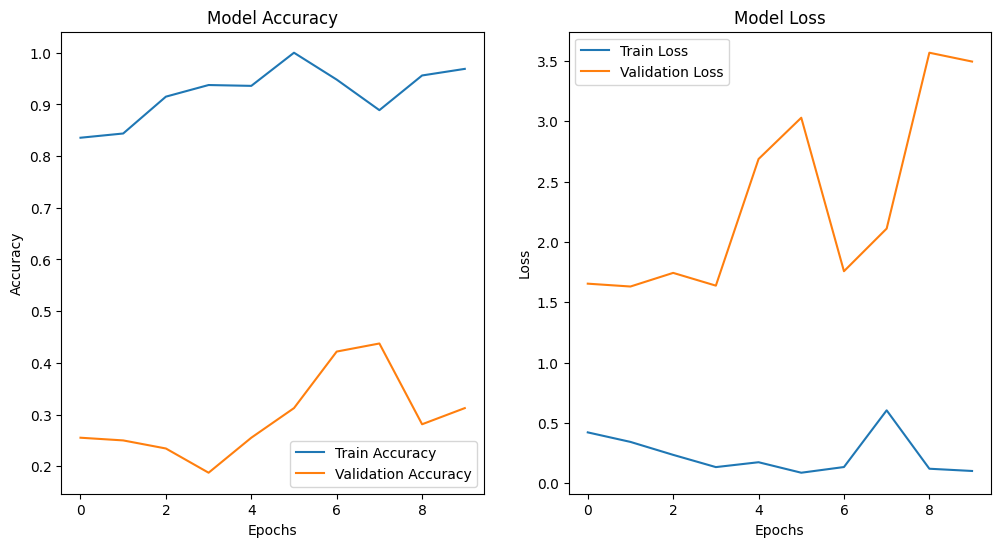

In [11]:
# Plot training and validation accuracy and loss curves
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [12]:
# Predict on test data
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class names

# Classification report
print('Classification Report')
print(classification_report(true_classes, y_pred, target_names=class_labels))

# Confusion matrix
print('Confusion Matrix')
print(confusion_matrix(true_classes, y_pred))


132/132 ━━━━━━━━━━━━━━━━━━━━ 48s 344ms/step
Classification Report
                      precision    recall  f1-score   support

            cataract       0.25      1.00      0.40      1038
diabetic_retinopathy       0.91      0.10      0.18      1098
            glaucoma       0.00      0.00      0.00      1007
              normal       0.00      0.00      0.00      1074

            accuracy                           0.27      4217
           macro avg       0.29      0.27      0.15      4217
        weighted avg       0.30      0.27      0.15      4217

Confusion Matrix
[[1038    0    0    0]
 [ 991  107    0    0]
 [1002    5    0    0]
 [1068    6    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test data
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # Get class names

# Generate classification report for Precision, Recall, F1-score, and Support
print('Classification Report:')
print(classification_report(true_classes, y_pred, target_names=class_labels))

# Generate confusion matrix for additional insights
print('Confusion Matrix:')
print(confusion_matrix(true_classes, y_pred))


132/132 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.25      1.00      0.40      1038
diabetic_retinopathy       0.91      0.10      0.18      1098
            glaucoma       0.00      0.00      0.00      1007
              normal       0.00      0.00      0.00      1074

            accuracy                           0.27      4217
           macro avg       0.29      0.27      0.15      4217
        weighted avg       0.30      0.27      0.15      4217

Confusion Matrix:
[[1038    0    0    0]
 [ 991  107    0    0]
 [1002    5    0    0]
 [1068    6    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test data
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get true labels
true_classes = test_generator.classes

# Ensure that class_labels matches the number of classes predicted by the model
class_labels = list(test_generator.class_indices.keys())
num_classes = len(np.unique(y_pred)) # Get the number of unique classes in the predictions
if len(class_labels) != num_classes:
  print(f"WARNING: Number of classes in 'class_labels' ({len(class_labels)}) does not match the number of classes predicted by the model ({num_classes}).\n This may lead to errors in the classification report.")
  # Option 1: Adjust class_labels to match the predicted classes (use with caution!)
  # class_labels = class_labels[:num_classes]
  # Option 2: Investigate why a class may be missing from the predictions and fix the underlying issue.


# Generate classification report for Precision, Recall, F1-score, and Support
print('Classification Report:')
print(classification_report(true_classes, y_pred, target_names=class_labels))

# Generate confusion matrix for additional insights
print('Confusion Matrix:')
print(confusion_matrix(true_classes, y_pred))

132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 311ms/step
 This may lead to errors in the classification report.
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.25      1.00      0.40      1038
diabetic_retinopathy       0.91      0.10      0.18      1098
            glaucoma       0.00      0.00      0.00      1007
              normal       0.00      0.00      0.00      1074

            accuracy                           0.27      4217
           macro avg       0.29      0.27      0.15      4217
        weighted avg       0.30      0.27      0.15      4217

Confusion Matrix:
[[1038    0    0    0]
 [ 991  107    0    0]
 [1002    5    0    0]
 [1068    6    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
